## Importing the relevant packages

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.graphics.tsaplots as sgt
import statsmodels.tsa.stattools as sts
from statsmodels.tsa.arima_model import ARIMA, ARMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from scipy.stats.distributions import chi2 
from math import sqrt
import seaborn as sns
sns.set()
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [15]:
from influxdb_client import InfluxDBClient

In [16]:
import warnings
warnings.filterwarnings("ignore")

## Importing the Data and Pre-processing 

In [4]:
#Auth parameters
my_token = "yaKfFeAsha8tNAZxvYeZBMmq-khO8tz-6Ut_PARgohiWzeW2j8BB86ND33Qbq7hR8bylmOROPQAUr-7M103_Yw=="
my_org = "iot-org"
bucket = "iot-demo"
client = InfluxDBClient(url="http://192.168.1.100:9999", token=my_token, org=my_org, debug=False)

In [11]:
days = '9d'
n_days = 9

queryTemperature = '''
from(bucket: "iot-demo")
  |> range(start: -%s, stop: now())
  |> filter(fn: (r) => r["_measurement"] == "temperature")
  |> filter(fn: (r) => r["device"] == "RoomWeather")
  |> aggregateWindow(every: 5m, fn: median)
  ''' % days

queryHumidity = '''
from(bucket: "iot-demo")
  |> range(start: -%s, stop: now())
  |> filter(fn: (r) => r["_measurement"] == "humidity")
  |> filter(fn: (r) => r["device"] == "RoomWeather")
  |> aggregateWindow(every: 5m, fn: median)
  ''' % days

queryPressure = '''
from(bucket: "iot-demo")
  |> range(start: -%s, stop: now())
  |> filter(fn: (r) => r["_measurement"] == "pressure")
  |> filter(fn: (r) => r["device"] == "RoomWeather")
  |> aggregateWindow(every: 5m, fn: median)
  ''' % days



In [6]:
#Query InfluxDB and return a Dataframe
dfTemp = client.query_api().query_data_frame(org=my_org, query=queryTemperature)
dfHum = client.query_api().query_data_frame(org=my_org, query=queryHumidity)
dfPress = client.query_api().query_data_frame(org=my_org, query=queryPressure)

In [7]:
dfTemp.head()

,result,table,_start,_stop,_field,_measurement,device,location,_value,_time
0,_result,0,2020-07-08 12:32:44.248397+00:00,2020-07-16 12:32:44.248397+00:00,value,temperature,RoomWeather,ubuntu,28.9,2020-07-08 12:35:00+00:00
1,_result,0,2020-07-08 12:32:44.248397+00:00,2020-07-16 12:32:44.248397+00:00,value,temperature,RoomWeather,ubuntu,29.0,2020-07-08 12:40:00+00:00
2,_result,0,2020-07-08 12:32:44.248397+00:00,2020-07-16 12:32:44.248397+00:00,value,temperature,RoomWeather,ubuntu,29.1,2020-07-08 12:45:00+00:00
3,_result,0,2020-07-08 12:32:44.248397+00:00,2020-07-16 12:32:44.248397+00:00,value,temperature,RoomWeather,ubuntu,29.2,2020-07-08 12:50:00+00:00
4,_result,0,2020-07-08 12:32:44.248397+00:00,2020-07-16 12:32:44.248397+00:00,value,temperature,RoomWeather,ubuntu,29.5,2020-07-08 12:55:00+00:00


In [8]:
dfHum.head()

,result,table,_start,_stop,_field,_measurement,device,location,_value,_time
0,_result,0,2020-07-08 12:32:50.261019+00:00,2020-07-16 12:32:50.261019+00:00,value,humidity,RoomWeather,ubuntu,40.7,2020-07-08 12:35:00+00:00
1,_result,0,2020-07-08 12:32:50.261019+00:00,2020-07-16 12:32:50.261019+00:00,value,humidity,RoomWeather,ubuntu,40.7,2020-07-08 12:40:00+00:00
2,_result,0,2020-07-08 12:32:50.261019+00:00,2020-07-16 12:32:50.261019+00:00,value,humidity,RoomWeather,ubuntu,40.6,2020-07-08 12:45:00+00:00
3,_result,0,2020-07-08 12:32:50.261019+00:00,2020-07-16 12:32:50.261019+00:00,value,humidity,RoomWeather,ubuntu,40.5,2020-07-08 12:50:00+00:00
4,_result,0,2020-07-08 12:32:50.261019+00:00,2020-07-16 12:32:50.261019+00:00,value,humidity,RoomWeather,ubuntu,40.3,2020-07-08 12:55:00+00:00


In [9]:
dfPress.head()

,result,table,_start,_stop,_field,_measurement,device,location,_value,_time
0,_result,0,2020-07-08 12:32:56.185984+00:00,2020-07-16 12:32:56.185984+00:00,value,pressure,RoomWeather,ubuntu,1020.500000,2020-07-08 12:35:00+00:00
1,_result,0,2020-07-08 12:32:56.185984+00:00,2020-07-16 12:32:56.185984+00:00,value,pressure,RoomWeather,ubuntu,1020.500000,2020-07-08 12:40:00+00:00
2,_result,0,2020-07-08 12:32:56.185984+00:00,2020-07-16 12:32:56.185984+00:00,value,pressure,RoomWeather,ubuntu,1020.500000,2020-07-08 12:45:00+00:00
3,_result,0,2020-07-08 12:32:56.185984+00:00,2020-07-16 12:32:56.185984+00:00,value,pressure,RoomWeather,ubuntu,1020.333333,2020-07-08 12:50:00+00:00
4,_result,0,2020-07-08 12:32:56.185984+00:00,2020-07-16 12:32:56.185984+00:00,value,pressure,RoomWeather,ubuntu,1020.500000,2020-07-08 12:55:00+00:00


In [12]:
df = pd.DataFrame(dfTemp['_time']).rename(columns={'_time':'time'})
df['temperature'] = dfTemp['_value']
df['humidity'] = dfHum['_value']
df['pressure'] = dfPress['_value']
df = df.set_index('time')
df = df.asfreq(freq='300S')
df.head(10)

NameError: name 'dfTemp' is not defined

In [17]:
df = pd.read_csv("dataframe_11g_5m.csv")
df.time = pd.to_datetime(df.time, dayfirst = True)
df.set_index('time',inplace=True)
points_per_day = 288 
n_days = 11
df

,temperature,humidity,pressure,people
time,,,,
2020-07-07 13:30:00+00:00,29.70,44.45,1019.5,0.0
2020-07-07 13:35:00+00:00,29.70,44.30,1019.5,0.0
2020-07-07 13:40:00+00:00,29.70,44.30,1019.5,0.0
2020-07-07 13:45:00+00:00,29.75,44.05,1019.5,0.0
2020-07-07 13:50:00+00:00,29.75,44.05,1019.5,0.0
...,...,...,...,...
2020-07-18 13:05:00+00:00,29.25,47.35,1018.4,1.0
2020-07-18 13:10:00+00:00,29.25,47.35,1018.4,1.0
2020-07-18 13:15:00+00:00,29.25,47.35,1018.4,1.0


# Fill NaN values

In [18]:
df['temperature'] = df['temperature'].fillna(method='backfill').fillna(method='ffill')
df['humidity'] = df['humidity'].fillna(method='backfill').fillna(method='ffill')
df['pressure'] = df['pressure'].fillna(method='backfill').fillna(method='ffill')

In [19]:
points_per_day = int(len(df)/n_days) 
points_per_day

288

In [20]:
print(df['temperature'].isnull().sum())
print(df['humidity'].isnull().sum())
print(df['pressure'].isnull().sum())

0
0
0


# Split the dataset

In [21]:
# divide in train e test
#size = int(len(df)*0.8)
size = len(df)-points_per_day
df_train, df_test = df.iloc[:size], df.iloc[size:]

In [22]:
df_test.head()

,temperature,humidity,pressure,people
time,,,,
2020-07-17 13:30:00+00:00,29.30,54.3,1016.500000,0.0
2020-07-17 13:35:00+00:00,29.10,54.5,1016.555556,0.0
2020-07-17 13:40:00+00:00,29.10,54.5,1016.555556,0.0
2020-07-17 13:45:00+00:00,29.15,54.7,1016.555556,0.0
2020-07-17 13:50:00+00:00,29.15,54.7,1016.555556,0.0


In [23]:
df_test.tail()

,temperature,humidity,pressure,people
time,,,,
2020-07-18 13:05:00+00:00,29.25,47.35,1018.4,1.0
2020-07-18 13:10:00+00:00,29.25,47.35,1018.4,1.0
2020-07-18 13:15:00+00:00,29.25,47.35,1018.4,1.0
2020-07-18 13:20:00+00:00,29.25,47.35,1018.4,1.0
2020-07-18 13:25:00+00:00,29.25,47.35,1018.4,1.0


# Dickey–Fuller test

In [24]:
sts.adfuller(df.temperature) # stazionaria

(-4.3218030067351245,
 0.00040713953032198814,
 28,
 3139,
 {'1%': -3.43243494922729,
  '5%': -2.8624612019435536,
  '10%': -2.5672603774676577},
 -5579.439576253486)

In [25]:
sts.adfuller(df.humidity) # non stazionaria

(-2.508104170625958,
 0.11351492395948476,
 18,
 3149,
 {'1%': -3.432428322829966,
  '5%': -2.8624582751958285,
  '10%': -2.5672588193169945},
 -734.6126810362912)

In [26]:
sts.adfuller(df.pressure) # non stazionaria

(-1.9304460578334657,
 0.3178766249543116,
 24,
 3143,
 {'1%': -3.432432293604288,
  '5%': -2.862460029008544,
  '10%': -2.5672597530168955},
 -2794.548696586955)

## The LLR Test

In [27]:
def LLR_test(mod_1, mod_2, DF = 1):
    L1 = mod_1.llf
    L2 = mod_2.llf
    LR = (2*(L2-L1))    
    p = chi2.sf(LR, DF).round(3)
    return p

## Auto Correlation Function (ACF)

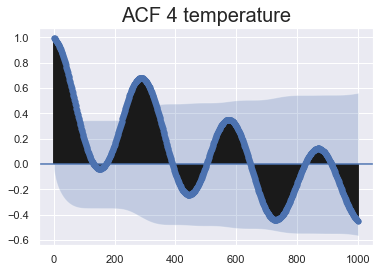

In [28]:
sgt.plot_acf(df.temperature, zero = False, lags = 1000)
plt.title("ACF 4 temperature", size = 20)
plt.show()

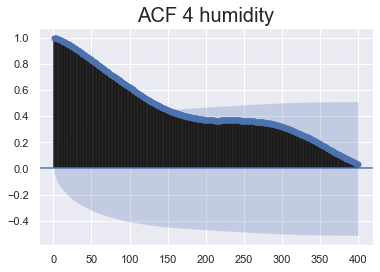

In [29]:
sgt.plot_acf(df.humidity, zero = False, lags = 400)
plt.title("ACF 4 humidity", size = 20)
plt.show()

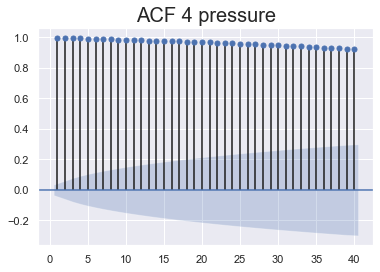

In [30]:
sgt.plot_acf(df.pressure, zero = False, lags = 40)
plt.title("ACF 4 pressure", size = 20)
plt.show()

## Partial Auto Correlation Function (PACF)

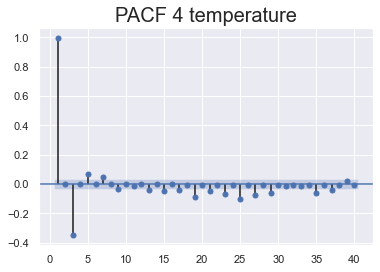

In [31]:
sgt.plot_pacf(df.temperature, lags = 40, alpha = 0.05, zero = False, method = ('ols'))
plt.title("PACF 4 temperature", size = 20)
plt.show()

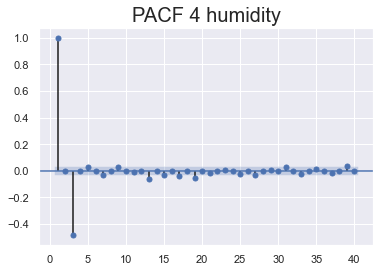

In [32]:
sgt.plot_pacf(df.humidity, lags = 40, alpha = 0.05, zero = False, method = ('ols'))
plt.title("PACF 4 humidity", size = 20)
plt.show()

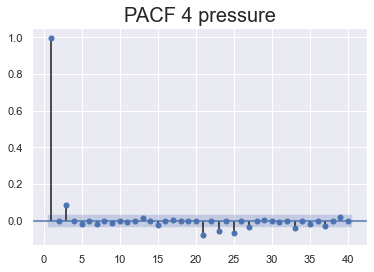

In [33]:
sgt.plot_pacf(df.pressure, lags = 40, alpha = 0.05, zero = False, method = ('ols'))
plt.title("PACF 4 pressure", size = 20)
plt.show()

# Temperature

## AR

In [34]:
print("AR(1)")
model_t_ar_1 = SARIMAX(df_train.temperature, order=(1,0,0))
results_t_ar_1 = model_t_ar_1.fit()
print(results_t_ar_1.summary())

print("AR(2)")
model_t_ar_2 = SARIMAX(df_train.temperature, order=(2,0,0))
results_t_ar_2 = model_t_ar_2.fit()
print(results_t_ar_2.summary())

print("AR(3)")
model_t_ar_3 = SARIMAX(df_train.temperature, order=(3,0,0))
results_t_ar_3 = model_t_ar_3.fit()
print(results_t_ar_3.summary())

#print("AR(4)") #PARAMETRI NON SIGNIFICATIVI
#model_t_ar_4 = ARIMA(df_train.temperature, order=(4,0,0))
#results_t_ar_4 = model_t_ar_4.fit()
#print(results_t_ar_4.summary())

#print("AR(5)") #PARAMETRI NON SIGNIFICATIVI
#model_t_ar_5 = ARIMA(df_train.temperature, order=(5,0,0))
#results_t_ar_5 = model_t_ar_5.fit()
#print(results_t_ar_5.summary())

AR(1)
                               SARIMAX Results                                
Dep. Variable:            temperature   No. Observations:                 2880
Model:               SARIMAX(1, 0, 0)   Log Likelihood                2262.752
Date:                Sat, 18 Jul 2020   AIC                          -4521.503
Time:                        15:46:29   BIC                          -4509.572
Sample:                    07-07-2020   HQIC                         -4517.203
                         - 07-17-2020                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0000   3.15e-05   3.17e+04      0.000       1.000       1.000
sigma2         0.0121      0.000    110.574      0.000       0.012       0.012
Ljung-Box (Q):                      703.25   J

In [35]:
print("AR(1):  \t LL = ", results_t_ar_1.llf, "\t AIC = ", results_t_ar_1.aic)
print("AR(2):  \t LL = ", results_t_ar_2.llf, "\t AIC = ", results_t_ar_2.aic)
print("AR(3):  \t LL = ", results_t_ar_3.llf, "\t AIC = ", results_t_ar_3.aic)

AR(1):  	 LL =  2262.7516816238985 	 AIC =  -4521.503363247797
AR(2):  	 LL =  2262.751566808163 	 AIC =  -4519.503133616326
AR(3):  	 LL =  2447.1574615489544 	 AIC =  -4886.314923097909


In [36]:
print("\nLLR test AR(1)-AR(2) = " + str(LLR_test(results_t_ar_1, results_t_ar_2)))
print("\nLLR test AR(2)-AR(3) = " + str(LLR_test(results_t_ar_2, results_t_ar_3)))
print("\nLLR test AR(1)-AR(3) = " + str(LLR_test(results_t_ar_1, results_t_ar_3, DF=2)))
#Deduciamo che AR(3) è il migliore e vale la pena di usarlo


LLR test AR(1)-AR(2) = 1.0

LLR test AR(2)-AR(3) = 0.0

LLR test AR(1)-AR(3) = 0.0


In [37]:
start_date = df_test.index[0]
end_date = df_test.index[points_per_day-1]

df_pred = results_t_ar_1.predict(start = start_date, end = end_date)
print("MSE AR(1)"+str(mean_squared_error(df_test.temperature[start_date:end_date], df_pred[start_date:end_date])))

df_pred = results_t_ar_2.predict(start = start_date, end = end_date)
print("MSE AR(2)"+str(mean_squared_error(df_test.temperature[start_date:end_date], df_pred[start_date:end_date])))

df_pred = results_t_ar_3.predict(start = start_date, end = end_date)
print("MSE AR(3)"+str(mean_squared_error(df_test.temperature[start_date:end_date], df_pred[start_date:end_date])))

MSE AR(1)0.5009173982175487
MSE AR(2)0.5009319225843193
MSE AR(3)0.5910070862847774


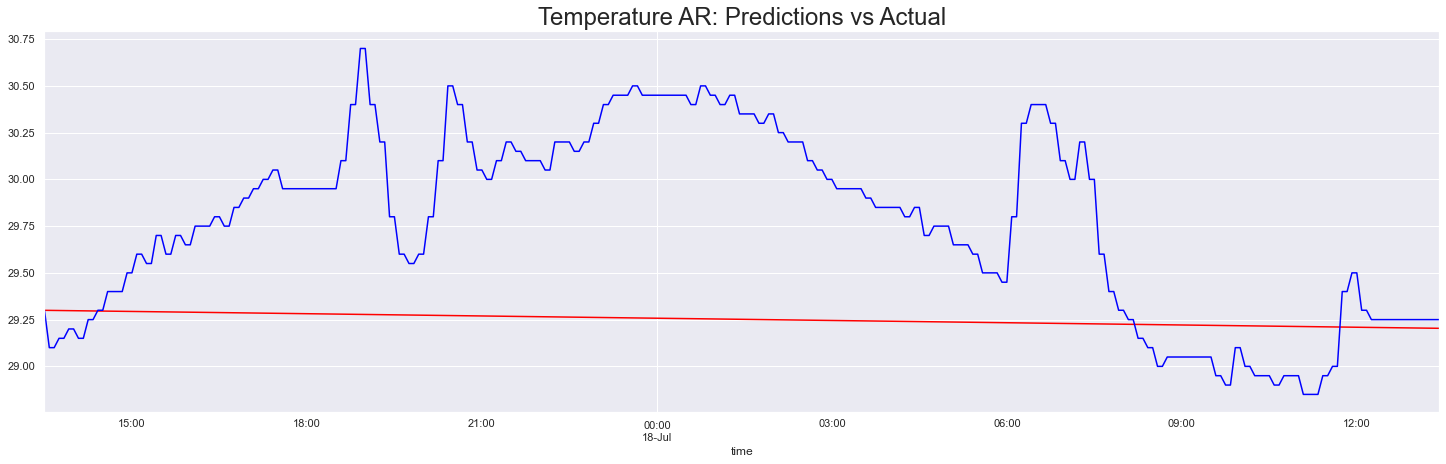

ABSOLUTE ERROR 0.5934723540331247
MSE 0.5009319225843193


In [39]:
df_pred = results_t_ar_2.predict(start = start_date, end = end_date)

df_pred[start_date:end_date].plot(figsize = (25,7), color = "red")
df_test.temperature[start_date:end_date].plot(color = "blue")
plt.title("Temperature AR: Predictions vs Actual", size = 24)
plt.show()                          

print("ABSOLUTE ERROR "+str(mean_absolute_error(df_test.temperature[start_date:end_date], df_pred[start_date:end_date])))
print("MSE "+str(mean_squared_error(df_test.temperature[start_date:end_date], df_pred[start_date:end_date])))

## MA

In [36]:
model_t_ma_1 = SARIMAX(df_train.temperature, order=(0,0,1))
results_t_ma_1 = model_t_ma_1.fit()
print(results_t_ma_1.summary())

#model_t_ma_2 = ARIMA(df.temperature, order=(0,0,2))
#results_t_ma_2 = model_t_ma_2.fit(start_ar_lags=100)
#print(results_t_ma_2.summary())

                               SARIMAX Results                                
Dep. Variable:            temperature   No. Observations:                 2016
Model:               SARIMAX(0, 0, 1)   Log Likelihood               -8335.746
Date:                Thu, 16 Jul 2020   AIC                          16675.492
Time:                        14:44:28   BIC                          16686.710
Sample:                    07-08-2020   HQIC                         16679.609
                         - 07-15-2020                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.9988      0.003    312.440      0.000       0.993       1.005
sigma2       227.8469     79.889      2.852      0.004      71.268     384.426
Ljung-Box (Q):                    38852.26   Jarque-

In [37]:
print("AR(1):  \t LL = ", results_t_ar_1.llf, "\t AIC = ", results_t_ar_1.aic)
print("AR(2):  \t LL = ", results_t_ar_2.llf, "\t AIC = ", results_t_ar_2.aic)
print("AR(3):  \t LL = ", results_t_ar_3.llf, "\t AIC = ", results_t_ar_3.aic)
print("MA(1):  \t LL = ", results_t_ma_1.llf, "\t AIC = ", results_t_ma_1.aic)
#MA fa decisamente più schifo degli AR

AR(1):  	 LL =  1761.195389958675 	 AIC =  -3518.39077991735
AR(2):  	 LL =  1898.337308296609 	 AIC =  -3790.674616593218
AR(3):  	 LL =  1906.2586063299425 	 AIC =  -3804.517212659885
MA(1):  	 LL =  -8335.74592347242 	 AIC =  16675.49184694484


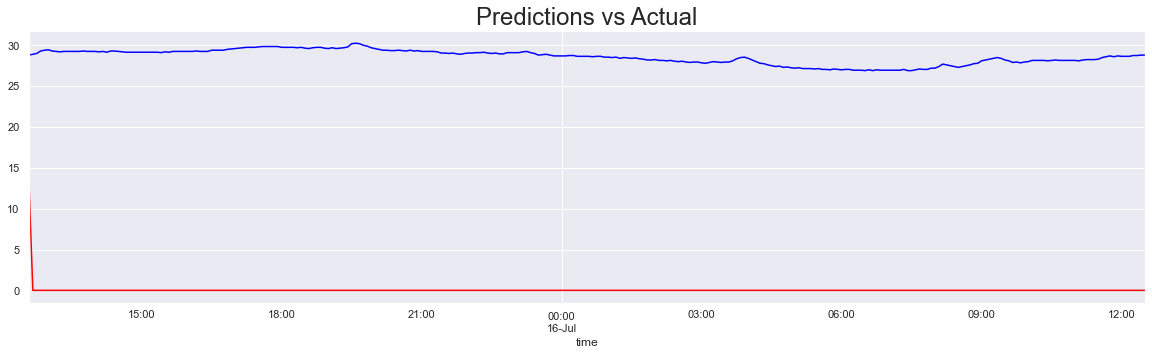

ABSOLUTE ERROR 28.531613030603832
MSE 815.4010125459741


In [41]:
df_pred = results_t_ma_1.predict(start = start_date, end = end_date)

df_pred[start_date:end_date].plot(figsize = (20,5), color = "red")
df_test.temperature[start_date:end_date].plot(color = "blue")
plt.title("Predictions vs Actual", size = 24)
plt.show()                          

print("ABSOLUTE ERROR "+str(mean_absolute_error(df_test.temperature[start_date:end_date], df_pred[start_date:end_date])))
print("MSE "+str(mean_squared_error(df_test.temperature[start_date:end_date], df_pred[start_date:end_date])))

## ARMA

In [42]:
print("\nARMA(1,1)")
reults_t_ar_1_ma_1 = SARIMAX(df_train.temperature, order=(1,0,1)).fit()
print(reults_t_ar_1_ma_1.summary())

print("\nARMA(2,1)")
reults_t_ar_2_ma_1 = SARIMAX(df_train.temperature, order=(2,0,1)).fit()
print(reults_t_ar_2_ma_1.summary())

print("\nARMA(1,2)")
reults_t_ar_1_ma_2 = SARIMAX(df_train.temperature, order=(1,0,2)).fit()
print(reults_t_ar_1_ma_2.summary())

print("\nARMA(2,2)") #NON SIGNIFICATIVO
reults_t_ar_2_ma_2 = SARIMAX(df_train.temperature, order=(2,0,2)).fit()
print(reults_t_ar_2_ma_2.summary())

print("\nARMA(3,1)") #NON SIGNIFICATIVO
reults_t_ar_3_ma_1 = SARIMAX(df_train.temperature, order=(3,0,1)).fit()
print(reults_t_ar_3_ma_1.summary())

print("\nARMA(1,3)")
reults_t_ar_1_ma_3 = SARIMAX(df_train.temperature, order=(1,0,3)).fit()
print(reults_t_ar_1_ma_3.summary())

print("\nARMA(3,2)")
reults_t_ar_3_ma_2 = SARIMAX(df_train.temperature, order=(3,0,2)).fit()
print(reults_t_ar_3_ma_2.summary())

print("\nARMA(2,3)") #NON SIGNIFICATIVO
reults_t_ar_2_ma_3 = SARIMAX(df_train.temperature, order=(2,0,3)).fit()
print(reults_t_ar_2_ma_3.summary())

print("\nARMA(3,3)") #NON SIGNIFICATIVO
reults_t_ar_3_ma_3 = SARIMAX(df_train.temperature, order=(3,0,3)).fit()
print(reults_t_ar_3_ma_3.summary())


ARMA(1,1)
                               SARIMAX Results                                
Dep. Variable:            temperature   No. Observations:                 2016
Model:               SARIMAX(1, 0, 1)   Log Likelihood                1868.698
Date:                Thu, 16 Jul 2020   AIC                          -3731.397
Time:                        14:45:23   BIC                          -3714.570
Sample:                    07-08-2020   HQIC                         -3725.221
                         - 07-15-2020                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0000   4.76e-05    2.1e+04      0.000       1.000       1.000
ma.L1          0.2897      0.018     16.275      0.000       0.255       0.325
sigma2         0.0091      0.000     50.2

                               SARIMAX Results                                
Dep. Variable:            temperature   No. Observations:                 2016
Model:               SARIMAX(1, 0, 3)   Log Likelihood                1906.433
Date:                Thu, 16 Jul 2020   AIC                          -3802.866
Time:                        14:45:25   BIC                          -3774.822
Sample:                    07-08-2020   HQIC                         -3792.573
                         - 07-15-2020                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0000   5.47e-05   1.83e+04      0.000       1.000       1.000
ma.L1          0.3223      0.018     17.978      0.000       0.287       0.357
ma.L2          0.1909      0.018     10.478      0.0

In [54]:
print("AR(1):  \t LL = ", results_t_ar_1.llf, "\t AIC = ", results_t_ar_1.aic)
print("AR(2):  \t LL = ", results_t_ar_2.llf, "\t AIC = ", results_t_ar_2.aic)
print("AR(3):  \t LL = ", results_t_ar_3.llf, "\t AIC = ", results_t_ar_3.aic)
print("MA(1):  \t LL = ", results_t_ma_1.llf, "\t AIC = ", results_t_ma_1.aic)

print("\n")

print("ARMA(1,1):  \t LL = ", reults_t_ar_1_ma_1.llf, "\t AIC = ", reults_t_ar_1_ma_1.aic)
print("ARMA(2,1):  \t LL = ", reults_t_ar_2_ma_1.llf, "\t AIC = ", reults_t_ar_2_ma_1.aic)
print("ARMA(1,2):  \t LL = ", reults_t_ar_1_ma_2.llf, "\t AIC = ", reults_t_ar_1_ma_2.aic)
print("ARMA(1,3):  \t LL = ", reults_t_ar_1_ma_3.llf, "\t AIC = ", reults_t_ar_1_ma_3.aic)
print("ARMA(3,2):  \t LL = ", reults_t_ar_3_ma_2.llf, "\t AIC = ", reults_t_ar_3_ma_2.aic)

AR(1):  	 LL =  1761.195389958675 	 AIC =  -3518.39077991735
AR(2):  	 LL =  1898.337308296609 	 AIC =  -3790.674616593218
AR(3):  	 LL =  1906.2586063299425 	 AIC =  -3804.517212659885
MA(1):  	 LL =  -8335.74592347242 	 AIC =  16675.49184694484


ARMA(1,1):  	 LL =  1868.6982907309846 	 AIC =  -3731.396581461969
ARMA(2,1):  	 LL =  1905.3335552828798 	 AIC =  -3802.6671105657597
ARMA(1,2):  	 LL =  1897.7859319614413 	 AIC =  -3787.5718639228826
ARMA(1,3):  	 LL =  1906.4331721567848 	 AIC =  -3802.8663443135697
ARMA(3,2):  	 LL =  1904.42267577539 	 AIC =  -3796.84535155078


In [55]:
print("\nAR(3) vs ARMA(2,1) ",LLR_test(results_t_ar_2, reults_t_ar_2_ma_1))
print("\nAR(3) vs ARMA(1,3) ",LLR_test(results_t_ar_2, reults_t_ar_1_ma_3))
print("\nAR(3) vs ARMA(2,3) ",LLR_test(results_t_ar_2, reults_t_ar_2_ma_3))
print("")
print("\nARMA(2,1) vs ARMA(2,3) ",LLR_test(reults_t_ar_2_ma_1, reults_t_ar_2_ma_3))
print("\nARMA(1,3) vs ARMA(2,3) ",LLR_test(reults_t_ar_1_ma_3, reults_t_ar_2_ma_3))


AR(3) vs ARMA(2,1)  0.0

AR(3) vs ARMA(1,3)  0.0

AR(3) vs ARMA(2,3)  0.0


ARMA(2,1) vs ARMA(2,3)  0.035

ARMA(1,3) vs ARMA(2,3)  0.134


In [56]:
start_date = df_test.index[0]
end_date = df_test.index[points_per_day-1]

df_pred = results_t_ar_1.predict(start = start_date, end = end_date)
print("MSE AR(1)"+str(mean_squared_error(df_test.temperature[start_date:end_date], df_pred[start_date:end_date])))

df_pred = results_t_ar_2.predict(start = start_date, end = end_date)
print("MSE AR(2)"+str(mean_squared_error(df_test.temperature[start_date:end_date], df_pred[start_date:end_date])))

df_pred = results_t_ar_3.predict(start = start_date, end = end_date)
print("MSE AR(3)"+str(mean_squared_error(df_test.temperature[start_date:end_date], df_pred[start_date:end_date])))

df_pred = results_t_ma_1.predict(start = start_date, end = end_date)
print("MSE MA(1)"+str(mean_squared_error(df_test.temperature[start_date:end_date], df_pred[start_date:end_date])))

df_pred = reults_t_ar_1_ma_1.predict(start = start_date, end = end_date)
print("MSE ARMA(1,1)"+str(mean_squared_error(df_test.temperature[start_date:end_date], df_pred[start_date:end_date])))

df_pred = reults_t_ar_2_ma_1.predict(start = start_date, end = end_date)
print("MSE ARMA(2,1)"+str(mean_squared_error(df_test.temperature[start_date:end_date], df_pred[start_date:end_date])))

df_pred = reults_t_ar_1_ma_2.predict(start = start_date, end = end_date)
print("MSE ARMA(1,2)"+str(mean_squared_error(df_test.temperature[start_date:end_date], df_pred[start_date:end_date])))

df_pred = reults_t_ar_1_ma_3.predict(start = start_date, end = end_date)
print("MSE ARMA(1,3)"+str(mean_squared_error(df_test.temperature[start_date:end_date], df_pred[start_date:end_date])))

df_pred = reults_t_ar_3_ma_2.predict(start = start_date, end = end_date)
print("MSE ARMA(3,2)"+str(mean_squared_error(df_test.temperature[start_date:end_date], df_pred[start_date:end_date])))

MSE AR(1)0.7566211376305149
MSE AR(2)0.7405489314976069
MSE AR(3)0.7252151225793082
MSE MA(1)815.4010125459741
MSE ARMA(1,1)0.7425878964788204
MSE ARMA(2,1)0.7284129998982487
MSE ARMA(1,2)0.7147789641038966
MSE ARMA(1,3)0.7045701635075415
MSE ARMA(3,2)0.48607864546761864


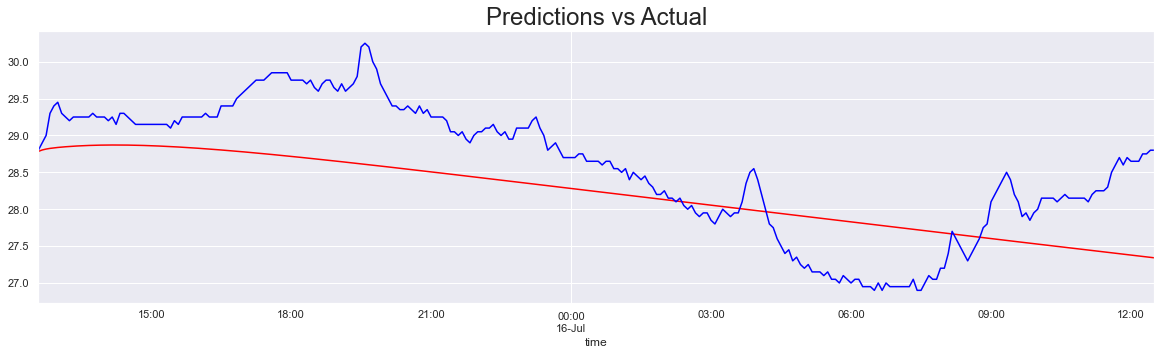

ABSOLUTE ERROR 0.6081266562026983
MSE 0.48607864546761864


In [48]:
df_pred = reults_t_ar_3_ma_2.predict(start = start_date, end = end_date)

df_pred[start_date:end_date].plot(figsize = (20,5), color = "red")
df_test.temperature[start_date:end_date].plot(color = "blue")
plt.title("Predictions vs Actual", size = 24)
plt.show()                          

print("ABSOLUTE ERROR "+str(mean_absolute_error(df_test.temperature[start_date:end_date], df_pred[start_date:end_date])))
print("MSE "+str(mean_squared_error(df_test.temperature[start_date:end_date], df_pred[start_date:end_date])))

### Analysis of Residuals ARMA

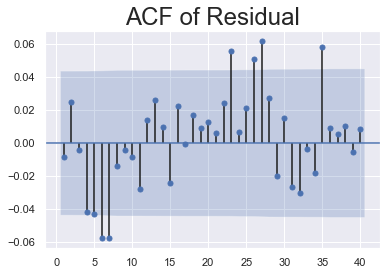

In [49]:
sgt.plot_acf(reults_t_ar_3_ma_2.resid.iloc[:][1:], zero = False, lags = 40)
plt.title("ACF of Residual", size=24)
plt.show()

## ARIMA

In [50]:
print("\nARIMA(1,1,1)") 
results_t_ar_1_i_1_ma_1 = SARIMAX(df_train.temperature, order=(1,1,1)).fit()
print(results_t_ar_1_i_1_ma_1.summary())

print("\nARIMA(2,1,1)") #NON SIGNIFICATIVO
results_t_ar_2_i_1_ma_1 = SARIMAX(df_train.temperature, order=(2,1,1)).fit()
print(results_t_ar_2_i_1_ma_1.summary())

print("\nARIMA(1,1,2)") #NON SIGNIFICATIVO
results_t_ar_1_i_1_ma_2 = SARIMAX(df_train.temperature, order=(1,1,2)).fit()
print(results_t_ar_1_i_1_ma_2.summary())

print("\nARIMA(1,1,3)") #NON SIGNIFICATIVO
results_t_ar_1_i_1_ma_3 = SARIMAX(df_train.temperature, order=(1,1,3)).fit()
print(results_t_ar_1_i_1_ma_3.summary())

print("\nARIMA(3,1,1)") #NON SIGNIFICATIVO
results_t_ar_3_i_1_ma_1 = SARIMAX(df_train.temperature, order=(3,1,1)).fit()
print(results_t_ar_3_i_1_ma_1.summary())

print("\nARIMA(3,1,2)") #NON SIGNIFICATIVO
results_t_ar_3_i_1_ma_2 = SARIMAX(df_train.temperature, order=(3,1,2)).fit()
print(results_t_ar_3_i_1_ma_2.summary())

print("\nARIMA(3,1,3)") #NON SIGNIFICATIVO
results_t_ar_3_i_1_ma_3 = SARIMAX(df_train.temperature, order=(3,1,3)).fit()
print(results_t_ar_3_i_1_ma_3.summary())


############################

print("\nARIMA(1,2,1)")
results_t_ar_1_i_2_ma_1 = SARIMAX(df_train.temperature, order=(1,2,1)).fit()
print(results_t_ar_1_i_2_ma_1.summary())

print("\nARIMA(2,2,1)")
results_t_ar_2_i_2_ma_1 = SARIMAX(df_train.temperature, order=(2,2,1)).fit()
print(results_t_ar_2_i_2_ma_1.summary())

print("\nARIMA(1,2,2)") 
results_t_ar_1_i_2_ma_2 = SARIMAX(df_train.temperature, order=(1,2,2)).fit()
print(results_t_ar_1_i_2_ma_2.summary())

print("\nARIMA(2,2,2)") #NON SIGNIFICATIVO
results_t_ar_2_i_2_ma_2 = SARIMAX(df_train.temperature, order=(2,2,2)).fit()
print(results_t_ar_2_i_2_ma_2.summary())


print("\nARIMA(1,2,3)") #NON SIGNIFICATIVO
results_t_ar_1_i_2_ma_3 = SARIMAX(df_train.temperature, order=(1,2,3)).fit()
print(results_t_ar_1_i_2_ma_3.summary())


ARIMA(1,1,1)
                               SARIMAX Results                                
Dep. Variable:            temperature   No. Observations:                 2016
Model:               SARIMAX(1, 1, 1)   Log Likelihood                1910.120
Date:                Thu, 16 Jul 2020   AIC                          -3814.240
Time:                        14:47:02   BIC                          -3797.415
Sample:                    07-08-2020   HQIC                         -3808.065
                         - 07-15-2020                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5371      0.036     14.767      0.000       0.466       0.608
ma.L1         -0.2062      0.043     -4.782      0.000      -0.291      -0.122
sigma2         0.0088      0.000     4

                               SARIMAX Results                                
Dep. Variable:            temperature   No. Observations:                 2016
Model:               SARIMAX(3, 1, 2)   Log Likelihood                1914.555
Date:                Thu, 16 Jul 2020   AIC                          -3817.110
Time:                        14:47:06   BIC                          -3783.459
Sample:                    07-08-2020   HQIC                         -3804.759
                         - 07-15-2020                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.3211      0.175      7.569      0.000       0.979       1.663
ar.L2         -0.6596      0.219     -3.008      0.003      -1.089      -0.230
ar.L3          0.0616      0.074      0.834      0.4

                               SARIMAX Results                                
Dep. Variable:            temperature   No. Observations:                 2016
Model:               SARIMAX(2, 2, 2)   Log Likelihood                1904.824
Date:                Thu, 16 Jul 2020   AIC                          -3799.647
Time:                        14:47:11   BIC                          -3771.608
Sample:                    07-08-2020   HQIC                         -3789.355
                         - 07-15-2020                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1908      0.251      0.762      0.446      -0.300       0.682
ar.L2          0.1115      0.083      1.341      0.180      -0.051       0.274
ma.L1         -0.8619      0.250     -3.444      0.0

In [51]:
print("ARMA(1,1,1):  \t LL = ", results_t_ar_1_i_1_ma_1.llf, "\t AIC = ", results_t_ar_1_i_1_ma_1.aic)
print("ARMA(1,2,1):  \t LL = ", results_t_ar_1_i_2_ma_1.llf, "\t AIC = ", results_t_ar_1_i_2_ma_1.aic)
print("ARMA(2,2,1):  \t LL = ", results_t_ar_2_i_2_ma_1.llf, "\t AIC = ", results_t_ar_2_i_2_ma_1.aic)
print("ARMA(1,2,2):  \t LL = ", results_t_ar_1_i_2_ma_2.llf, "\t AIC = ", results_t_ar_1_i_2_ma_2.aic)
#print("ARMA(1,2,3):  \t LL = ", results_t_ar_1_i_2_ma_3.llf, "\t AIC = ", results_t_ar_1_i_2_ma_3.aic)

ARMA(1,1,1):  	 LL =  1910.120088161475 	 AIC =  -3814.24017632295
ARMA(1,2,1):  	 LL =  1899.6769379414009 	 AIC =  -3793.3538758828017
ARMA(2,2,1):  	 LL =  1904.655053133414 	 AIC =  -3801.310106266828
ARMA(1,2,2):  	 LL =  1903.7000211396903 	 AIC =  -3799.4000422793806


In [52]:
#print("\nAR(2) vs ARIMA(1,1,2) ",LLR_test(results_t_ar_2, results_t_ar_1_i_1_ma_2))
#print("\nARMA(1,3) vs ARIMA(1,1,2) ",LLR_test(reults_t_ar_1_ma_3, results_t_ar_1_i_1_ma_2))
#print("\nARMA(2,3) vs ARIMA(1,1,2) ",LLR_test(reults_t_ar_2_ma_3, results_t_ar_1_i_1_ma_2))
#print("\nARMA(1,1,1) vs ARIMA(1,1,2) ",LLR_test(results_t_ar_1_i_1_ma_1, results_t_ar_1_i_1_ma_2))

In [53]:
start_date = df_test.index[0]
end_date = df_test.index[points_per_day-1]

df_pred = results_t_ar_1.predict(start = start_date, end = end_date)
print("MSE AR(1)"+str(mean_squared_error(df_test.temperature[start_date:end_date], df_pred[start_date:end_date])))

df_pred = results_t_ar_2.predict(start = start_date, end = end_date)
print("MSE AR(2)"+str(mean_squared_error(df_test.temperature[start_date:end_date], df_pred[start_date:end_date])))

df_pred = results_t_ar_3.predict(start = start_date, end = end_date)
print("MSE AR(3)"+str(mean_squared_error(df_test.temperature[start_date:end_date], df_pred[start_date:end_date])))

df_pred = results_t_ma_1.predict(start = start_date, end = end_date)
print("MSE MA(1)"+str(mean_squared_error(df_test.temperature[start_date:end_date], df_pred[start_date:end_date])))

df_pred = reults_t_ar_1_ma_1.predict(start = start_date, end = end_date)
print("MSE ARMA(1,1)"+str(mean_squared_error(df_test.temperature[start_date:end_date], df_pred[start_date:end_date])))

df_pred = reults_t_ar_2_ma_1.predict(start = start_date, end = end_date)
print("MSE ARMA(2,1)"+str(mean_squared_error(df_test.temperature[start_date:end_date], df_pred[start_date:end_date])))

df_pred = reults_t_ar_1_ma_2.predict(start = start_date, end = end_date)
print("MSE ARMA(1,2)"+str(mean_squared_error(df_test.temperature[start_date:end_date], df_pred[start_date:end_date])))

df_pred = reults_t_ar_1_ma_3.predict(start = start_date, end = end_date)
print("MSE ARMA(1,3)"+str(mean_squared_error(df_test.temperature[start_date:end_date], df_pred[start_date:end_date])))

df_pred = reults_t_ar_3_ma_2.predict(start = start_date, end = end_date)
print("MSE ARMA(3,2)"+str(mean_squared_error(df_test.temperature[start_date:end_date], df_pred[start_date:end_date])))

df_pred = results_t_ar_1_i_1_ma_1.predict(start = start_date, end = end_date)
print("MSE ARIMA(1,1,1)"+str(mean_squared_error(df_test.temperature[start_date:end_date], df_pred[start_date:end_date])))

df_pred = results_t_ar_1_i_2_ma_1.predict(start = start_date, end = end_date)
print("MSE ARIMA(1,2,1)"+str(mean_squared_error(df_test.temperature[start_date:end_date], df_pred[start_date:end_date])))

df_pred = results_t_ar_2_i_2_ma_1.predict(start = start_date, end = end_date)
print("MSE ARIMA(2,2,1)"+str(mean_squared_error(df_test.temperature[start_date:end_date], df_pred[start_date:end_date])))

df_pred = results_t_ar_1_i_2_ma_2.predict(start = start_date, end = end_date)
print("MSE ARIMA(1,2,2)"+str(mean_squared_error(df_test.temperature[start_date:end_date], df_pred[start_date:end_date])))

df_pred = results_t_ar_1_i_2_ma_3.predict(start = start_date, end = end_date)
print("MSE ARIMA(1,2,3)"+str(mean_squared_error(df_test.temperature[start_date:end_date], df_pred[start_date:end_date])))

MSE AR(1)0.7566211376305149
MSE AR(2)0.7405489314976069
MSE AR(3)0.7252151225793082
MSE MA(1)815.4010125459741
MSE ARMA(1,1)0.7425878964788204
MSE ARMA(2,1)0.7284129998982487
MSE ARMA(1,2)0.7147789641038966
MSE ARMA(1,3)0.7045701635075415
MSE ARIMA(1,1,1)0.8181938983823888
MSE ARIMA(1,2,1)19.60183556709488
MSE ARIMA(2,2,1)13.391633649298653
MSE ARIMA(1,2,2)13.818525051274712
MSE ARIMA(1,2,3)15.070053824344106


### Residuals of the ARIMA(1,1,1)

In [ ]:
#sgt.plot_acf(results_t_ar_1_i_2_ma_1.resid.iloc[:][1:], zero = False, lags = 40)
#plt.title("ACF of Residual for ARIMA(1,2,1)", size=24)
#plt.show()

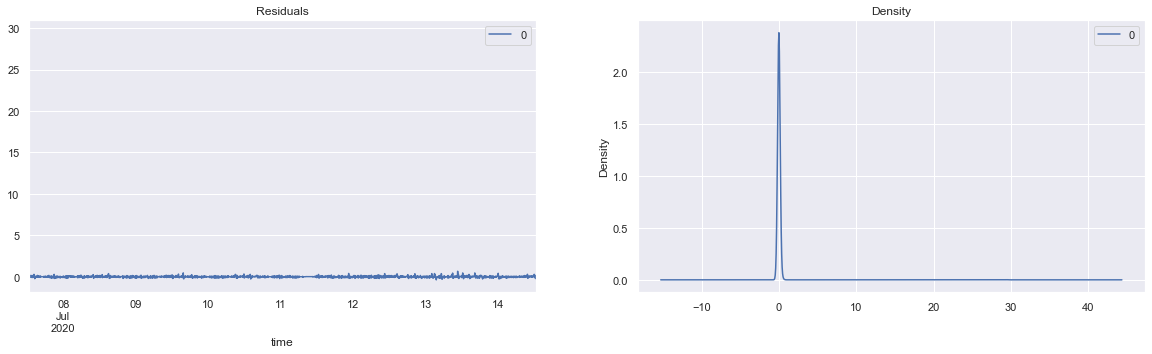

In [58]:
residuals = pd.DataFrame(results_t_ar_1_i_1_ma_1.resid)
fig, ax = plt.subplots(1,2)
residuals.plot(title="Residuals", ax=ax[0], figsize = (20,5))
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

### Prediction

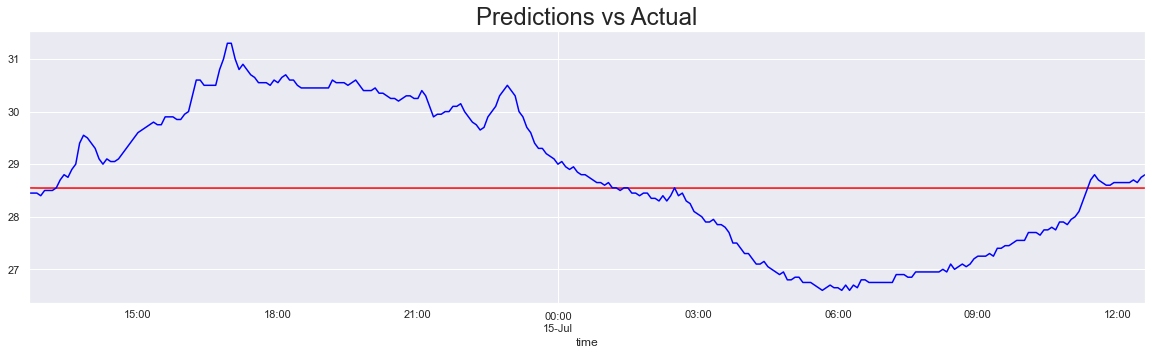

ABSOLUTE ERROR 1.1749120177340835
MSE 1.8753180126986808


In [62]:
df_pred = results_t_ar_1_i_1_ma_1.predict(start = start_date, end = end_date)

df_pred[start_date:end_date].plot(figsize = (20,5), color = "red")
df_test.temperature[start_date:end_date].plot(color = "blue")
plt.title("Predictions vs Actual", size = 24)
plt.show()                          

print("ABSOLUTE ERROR "+str(mean_absolute_error(df_test.temperature[start_date:end_date], df_pred[start_date:end_date])))
print("MSE "+str(mean_squared_error(df_test.temperature[start_date:end_date], df_pred[start_date:end_date])))

## ARIMAX

In [ ]:
#results_t_ar_2_i_0_ma_2_X_h = ARIMA(df.temperature, exog = df.humidity, order=(2,0,2)).fit() #ORDER?
#print(results_t_ar_2_i_0_ma_2_X_h.summary())
#results_t_ar_2_i_0_ma_2_X_p = ARIMA(df.temperature, exog = df.pressure, order=(2,1,2)).fit() #ORDER?
#print(results_t_ar_2_i_0_ma_2_X_p.summary())
#results_t_ar_2_i_0_ma_2_X_hp = ARIMA(df.temperature, exog = df[['pressure','humidity']], order=(2,1,2)).fit() #ORDER?
#print(results_t_ar_2_i_0_ma_2_X_hp.summary())

In [ ]:
#print("\nAR(2,2) vs ARIMAX(2,0,2) hum",LLR_test(reults_t_ar_2_ma_2, results_t_ar_2_i_0_ma_2_X_h))

## SARIMAX

In [ ]:
results_t_sarimax_h = SARIMAX(df.temperature, order=(0,0,1), seasonal_order = (0,1,0,points_per_day)).fit(maxiter=20) #ORDER? STAGIONALITY?
results_t_sarimax_h.summary()

In [ ]:
#results_t_sarimax_p = SARIMAX(df.temperature, order=(3,1,1), seasonal_order = (2,0,1,5)).fit() #ORDER? STAGIONALITY?
#results_t_sarimax_p.summary()

# Humidity

In [40]:
model_h_ar_1 = SARIMAX(df_train.humidity, order=(1,0,0))
results_h_ar_1 = model_h_ar_1.fit()
print(results_h_ar_1.summary())
model_h_ar_2 = SARIMAX(df_train.humidity, order=(2,0,0))
results_h_ar_2 = model_h_ar_2.fit()
print(results_h_ar_2.summary())
model_h_ar_3 = SARIMAX(df_train.humidity, order=(3,0,0)) 
results_h_ar_3 = model_h_ar_3.fit()
print(results_h_ar_3.summary())
model_h_ar_4 = SARIMAX(df_train.humidity, order=(4,0,0))  #NON SIGN
results_h_ar_4 = model_h_ar_4.fit()
print(results_h_ar_4.summary())

                               SARIMAX Results                                
Dep. Variable:               humidity   No. Observations:                 2880
Model:               SARIMAX(1, 0, 0)   Log Likelihood                -100.671
Date:                Sat, 18 Jul 2020   AIC                            205.341
Time:                        15:51:47   BIC                            217.272
Sample:                    07-07-2020   HQIC                           209.642
                         - 07-17-2020                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0000    8.5e-05   1.18e+04      0.000       1.000       1.000
sigma2         0.0626      0.001    118.150      0.000       0.062       0.064
Ljung-Box (Q):                      937.52   Jarque-

In [41]:
print("\nLLR test AR(1)-AR(2) = " + str(LLR_test(results_h_ar_1, results_h_ar_2)))
print("\nLLR test AR(1)-AR(3) = " + str(LLR_test(results_h_ar_1, results_h_ar_3, DF = 2)))
print("\nLLR test AR(2)-AR(3) = " + str(LLR_test(results_h_ar_2, results_h_ar_3)))


LLR test AR(1)-AR(2) = 1.0

LLR test AR(1)-AR(3) = 0.0

LLR test AR(2)-AR(3) = 0.0


### Predict with AR

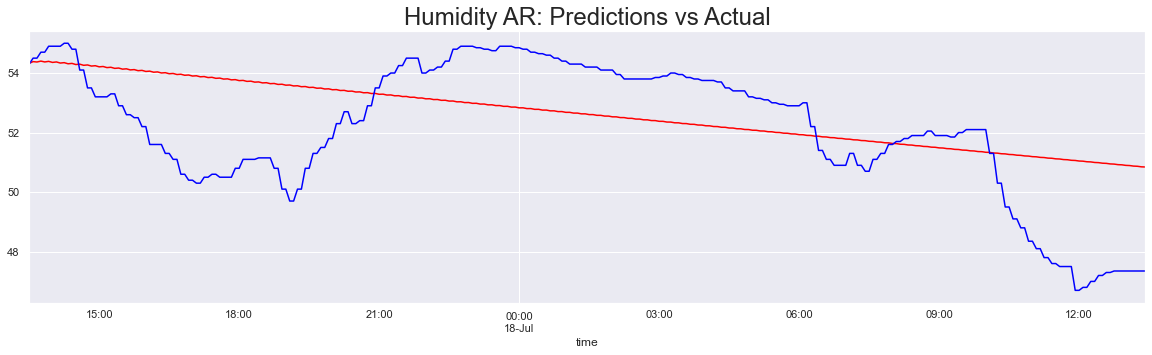

ABSOLUTE ERROR 1.6822779763228282
MSE 4.009999186868512


In [44]:
start_date = df_test.index[0]
end_date = df_test.index[len(df_test)-1]

df_pred = results_h_ar_4.predict(start = start_date, end = end_date)

df_pred[start_date:end_date].plot(figsize = (20,5), color = "red")
df_test.humidity[start_date:end_date].plot(color = "blue")
plt.title("Humidity AR: Predictions vs Actual", size = 24)
plt.show()                          

print("ABSOLUTE ERROR "+str(mean_absolute_error(df_test.humidity[start_date:end_date], df_pred[start_date:end_date])))
print("MSE "+str(mean_squared_error(df_test.humidity[start_date:end_date], df_pred[start_date:end_date])))

In [62]:
df_pred = results_h_ar_1.predict(start = start_date, end = end_date)
print("MSE AR(1)"+str(mean_squared_error(df_test.temperature[start_date:end_date], df_pred[start_date:end_date])))

df_pred = results_h_ar_2.predict(start = start_date, end = end_date)
print("MSE AR(2)"+str(mean_squared_error(df_test.temperature[start_date:end_date], df_pred[start_date:end_date])))

df_pred = results_h_ar_3.predict(start = start_date, end = end_date)
print("MSE AR(3)"+str(mean_squared_error(df_test.temperature[start_date:end_date], df_pred[start_date:end_date])))

MSE AR(1)129.45244366015976
MSE AR(2)128.81817650296856
MSE AR(3)128.94454826967416


### MA

In [65]:
model_h_ma_1 = SARIMAX(df_train.humidity, order=(0,0,1))
results_h_ma_1 = model_h_ma_1.fit()
print(results_h_ma_1.summary())

#model_h_ma_2 = ARMA(df.humidity, order=(0,2))
#results_h_ma_2 = model_h_ma_2.fit()
#print(results_h_ma_2.summary())

                               SARIMAX Results                                
Dep. Variable:               humidity   No. Observations:                 1728
Model:               SARIMAX(0, 0, 1)   Log Likelihood               -7796.307
Date:                Wed, 15 Jul 2020   AIC                          15596.615
Time:                        13:10:53   BIC                          15607.524
Sample:                    07-08-2020   HQIC                         15600.650
                         - 07-14-2020                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.9998      0.051     19.526      0.000       0.899       1.100
sigma2       483.7372    101.719      4.756      0.000     284.372     683.103
Ljung-Box (Q):                    54466.38   Jarque-

In [68]:
df_pred = results_h_ar_1.predict(start = start_date, end = end_date)
print("MSE AR(1)"+str(mean_squared_error(df_test.temperature[start_date:end_date], df_pred[start_date:end_date])))

df_pred = results_h_ar_2.predict(start = start_date, end = end_date)
print("MSE AR(2)"+str(mean_squared_error(df_test.temperature[start_date:end_date], df_pred[start_date:end_date])))

df_pred = results_h_ar_3.predict(start = start_date, end = end_date)
print("MSE AR(3)"+str(mean_squared_error(df_test.temperature[start_date:end_date], df_pred[start_date:end_date])))

df_pred = results_h_ma_1.predict(start = start_date, end = end_date)
print("MSE MA(1)"+str(mean_squared_error(df_test.temperature[start_date:end_date], df_pred[start_date:end_date])))

MSE AR(1)129.45244366015976
MSE AR(2)128.81817650296856
MSE AR(3)128.94454826967416
MSE MA(1)824.6791314500165


### ARMA

In [70]:
print("\nARMA(1,1)")
reults_h_ar_1_ma_1 = SARIMAX(df_train.humidity, order=(1,0,1)).fit()
print(reults_h_ar_1_ma_1.summary())

print("\nARMA(2,1)") 
reults_h_ar_2_ma_1 = SARIMAX(df_train.humidity, order=(2,0,1)).fit()
print(reults_h_ar_2_ma_1.summary())

print("\nARMA(1,2)")
reults_h_ar_1_ma_2 = SARIMAX(df_train.humidity, order=(1,0,2)).fit()
print(reults_h_ar_1_ma_2.summary())

print("\nARMA(2,2)") 
reults_h_ar_2_ma_2 = SARIMAX(df_train.humidity, order=(2,0,2)).fit()
print(reults_h_ar_2_ma_2.summary())

print("\nARMA(3,1)") #NON SIGNIFICATIVO
reults_h_ar_3_ma_1 = SARIMAX(df_train.humidity, order=(3,0,1)).fit()
print(reults_h_ar_3_ma_1.summary())

print("\nARMA(1,3)")
reults_h_ar_1_ma_3 = SARIMAX(df_train.humidity, order=(1,0,3)).fit()
print(reults_h_ar_1_ma_3.summary())

print("\nARMA(3,2)") #NON SIGNIFICATIVO
reults_h_ar_3_ma_2 = SARIMAX(df_train.humidity, order=(3,0,2)).fit()
print(reults_h_ar_3_ma_2.summary())

print("\nARMA(2,3)") #NON SIGNIFICATIVO
reults_h_ar_2_ma_3 = SARIMAX(df_train.humidity, order=(2,0,3)).fit()
print(reults_h_ar_2_ma_3.summary())

print("\nARMA(3,3)") #NON SIGNIFICATIVO
reults_h_ar_3_ma_3 = SARIMAX(df_train.humidity, order=(3,0,3)).fit()
print(reults_h_ar_3_ma_3.summary())


ARMA(1,1)
                               SARIMAX Results                                
Dep. Variable:               humidity   No. Observations:                 1728
Model:               SARIMAX(1, 0, 1)   Log Likelihood                 520.293
Date:                Wed, 15 Jul 2020   AIC                          -1034.587
Time:                        13:12:53   BIC                          -1018.222
Sample:                    07-08-2020   HQIC                         -1028.534
                         - 07-14-2020                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9999   4.77e-05    2.1e+04      0.000       1.000       1.000
ma.L1          0.4161      0.016     26.367      0.000       0.385       0.447
sigma2         0.0319      0.001     52.6

                               SARIMAX Results                                
Dep. Variable:               humidity   No. Observations:                 1728
Model:               SARIMAX(1, 0, 3)   Log Likelihood                 562.841
Date:                Wed, 15 Jul 2020   AIC                          -1115.682
Time:                        13:12:55   BIC                          -1088.409
Sample:                    07-08-2020   HQIC                         -1105.594
                         - 07-14-2020                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0000   9.35e-05   1.07e+04      0.000       1.000       1.000
ma.L1          0.4655      0.016     29.289      0.000       0.434       0.497
ma.L2          0.2105      0.018     11.565      0.0

In [71]:
print("AR(1):  \t LL = ", results_h_ar_1.llf, "\t AIC = ", results_h_ar_1.aic)
print("AR(2):  \t LL = ", results_h_ar_2.llf, "\t AIC = ", results_h_ar_2.aic)
print("MA(1):  \t LL = ", results_h_ma_1.llf, "\t AIC = ", results_h_ma_1.aic)

print("\n")

print("ARMA(1,1):  \t LL = ", reults_h_ar_1_ma_1.llf, "\t AIC = ", reults_h_ar_1_ma_1.aic)
print("ARMA(2,1):  \t LL = ", reults_h_ar_2_ma_1.llf, "\t AIC = ", reults_h_ar_2_ma_1.aic)
print("ARMA(1,2):  \t LL = ", reults_h_ar_1_ma_2.llf, "\t AIC = ", reults_h_ar_1_ma_2.aic)
print("ARMA(2,2):  \t LL = ", reults_h_ar_2_ma_2.llf, "\t AIC = ", reults_h_ar_2_ma_2.aic)
print("ARMA(1,3):  \t LL = ", reults_h_ar_1_ma_3.llf, "\t AIC = ", reults_h_ar_1_ma_3.aic)

AR(1):  	 LL =  330.5163931648456 	 AIC =  -657.0327863296912
AR(2):  	 LL =  571.2607017493154 	 AIC =  -1136.521403498631
MA(1):  	 LL =  -7796.307320846572 	 AIC =  15596.614641693144


ARMA(1,1):  	 LL =  520.2933082181293 	 AIC =  -1034.5866164362585
ARMA(2,1):  	 LL =  573.8354700951586 	 AIC =  -1139.6709401903172
ARMA(1,2):  	 LL =  552.4524957108501 	 AIC =  -1096.9049914217003
ARMA(2,2):  	 LL =  577.7371379136855 	 AIC =  -1145.474275827371
ARMA(1,3):  	 LL =  562.8411904246341 	 AIC =  -1115.6823808492682


### Predictions

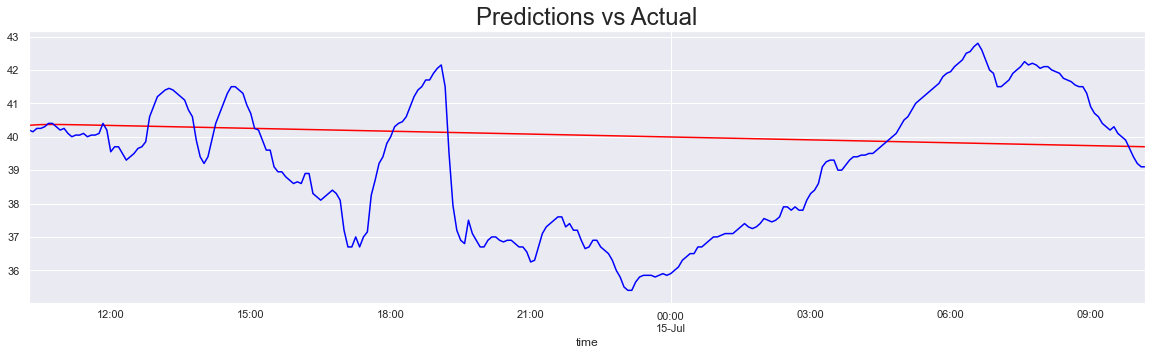

ABSOLUTE ERROR 1.8058860742471292
MSE 4.781547910493064


In [73]:
start_date = df_test.index[0]
end_date = df_test.index[len(df_test)-1]

df_pred = reults_h_ar_2_ma_2.predict(start = start_date, end = end_date)

df_pred[start_date:end_date].plot(figsize = (20,5), color = "red")
df_test.humidity[start_date:end_date].plot(color = "blue")
plt.title("Predictions vs Actual", size = 24)
plt.show()                          

print("ABSOLUTE ERROR "+str(mean_absolute_error(df_test.humidity[start_date:end_date], df_pred[start_date:end_date])))
print("MSE "+str(mean_squared_error(df_test.humidity[start_date:end_date], df_pred[start_date:end_date])))

### ARIMA

In [74]:
print("\nARIMA(1,1,1)") 
results_h_ar_1_i_1_ma_1 = SARIMAX(df_train.humidity, order=(1,1,1)).fit()
print(results_h_ar_1_i_1_ma_1.summary())

print("\nARIMA(2,1,1)") 
results_h_ar_2_i_1_ma_1 = SARIMAX(df_train.humidity, order=(2,1,1)).fit()
print(results_h_ar_2_i_1_ma_1.summary())

print("\nARIMA(1,1,2)") 
results_h_ar_1_i_1_ma_2 = SARIMAX(df_train.humidity, order=(1,1,2)).fit()
print(results_h_ar_1_i_1_ma_2.summary())

print("\nARIMA(2,1,2)") #NON SIGNIFICATIVO
results_h_ar_2_i_1_ma_2 = SARIMAX(df_train.humidity, order=(2,1,2)).fit()
print(results_h_ar_2_i_1_ma_2.summary())

print("\nARIMA(1,1,3)")  #NON SIGNIFICATIVO
results_h_ar_1_i_1_ma_3 = SARIMAX(df_train.humidity, order=(1,1,3)).fit()
print(results_h_ar_1_i_1_ma_3.summary())

print("\nARIMA(3,1,1)")  #NON SIGNIFICATIVO
results_h_ar_3_i_1_ma_1 = SARIMAX(df_train.humidity, order=(3,1,1)).fit()
print(results_h_ar_3_i_1_ma_1.summary())

print("\nARIMA(2,1,3)")   #NON SIGNIFICATIVO
results_h_ar_2_i_1_ma_3 = SARIMAX(df_train.humidity, order=(2,1,3)).fit()
print(results_h_ar_2_i_1_ma_3.summary())

print("\nARIMA(3,1,2)") 
results_h_ar_3_i_1_ma_2 = SARIMAX(df_train.humidity, order=(3,1,2)).fit()
print(results_h_ar_3_i_1_ma_2.summary())

print("\nARIMA(3,1,3)") #NON SIGNIFICATIVO
results_h_ar_3_i_1_ma_3 = SARIMAX(df_train.humidity, order=(3,1,3)).fit()
print(results_h_ar_3_i_1_ma_3.summary())


############################

print("\nARIMA(1,2,1)") 
results_h_ar_1_i_2_ma_1 = SARIMAX(df_train.humidity, order=(1,2,1)).fit()
print(results_h_ar_1_i_2_ma_1.summary())

print("\nARIMA(2,2,1)") 
results_h_ar_2_i_2_ma_1 = SARIMAX(df_train.humidity, order=(2,2,1)).fit()
print(results_h_ar_2_i_1_ma_1.summary())

print("\nARIMA(1,2,2)") 
results_h_ar_1_i_2_ma_2 = SARIMAX(df_train.humidity, order=(1,2,2)).fit()
print(results_h_ar_1_i_2_ma_2.summary())

print("\nARIMA(2,2,2)") #NON SIGNIFICATIVO
results_h_ar_2_i_2_ma_2 = SARIMAX(df_train.humidity, order=(2,2,2)).fit()
print(results_h_ar_2_i_2_ma_2.summary())

print("\nARIMA(1,2,3)") 
results_h_ar_1_i_2_ma_3 = SARIMAX(df_train.humidity, order=(1,2,3)).fit()
print(results_h_ar_1_i_2_ma_3.summary())

print("\nARIMA(3,2,1)") #NON SIGNIFICATIVO
results_h_ar_3_i_2_ma_1 = SARIMAX(df_train.humidity, order=(3,2,1)).fit()
print(results_h_ar_3_i_2_ma_1.summary())

print("\nARIMA(2,2,3)") #NON SIGNIFICATIVO
results_h_ar_2_i_2_ma_3 = SARIMAX(df_train.humidity, order=(2,2,3)).fit()
print(results_h_ar_2_i_2_ma_3.summary())

print("\nARIMA(3,2,2)") #NON SIGNIFICATIVO
results_h_ar_3_i_2_ma_2 = SARIMAX(df_train.humidity, order=(3,2,2)).fit()
print(results_h_ar_3_i_2_ma_2.summary())

print("\nARIMA(3,2,3)") 
results_h_ar_3_i_2_ma_3 = SARIMAX(df_train.humidity, order=(3,2,3)).fit()
print(results_h_ar_3_i_2_ma_3.summary())


ARIMA(1,1,1)
                               SARIMAX Results                                
Dep. Variable:               humidity   No. Observations:                 1728
Model:               SARIMAX(1, 1, 1)   Log Likelihood                 579.112
Date:                Wed, 15 Jul 2020   AIC                          -1152.224
Time:                        13:15:12   BIC                          -1135.862
Sample:                    07-08-2020   HQIC                         -1146.171
                         - 07-14-2020                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5892      0.026     22.791      0.000       0.539       0.640
ma.L1         -0.1292      0.030     -4.365      0.000      -0.187      -0.071
sigma2         0.0299      0.001     5

                               SARIMAX Results                                
Dep. Variable:               humidity   No. Observations:                 1728
Model:               SARIMAX(3, 1, 1)   Log Likelihood                 583.328
Date:                Wed, 15 Jul 2020   AIC                          -1156.655
Time:                        13:15:14   BIC                          -1129.385
Sample:                    07-08-2020   HQIC                         -1146.568
                         - 07-14-2020                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7345      0.224      3.278      0.001       0.295       1.174
ar.L2         -0.1145      0.101     -1.135      0.256      -0.312       0.083
ar.L3          0.0605      0.026      2.369      0.0

                               SARIMAX Results                                
Dep. Variable:               humidity   No. Observations:                 1728
Model:               SARIMAX(2, 1, 1)   Log Likelihood                 581.652
Date:                Wed, 15 Jul 2020   AIC                          -1155.304
Time:                        13:15:20   BIC                          -1133.487
Sample:                    07-08-2020   HQIC                         -1147.233
                         - 07-14-2020                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0759      0.127      8.486      0.000       0.827       1.324
ar.L2         -0.2416      0.067     -3.591      0.000      -0.373      -0.110
ma.L1         -0.6168      0.123     -5.010      0.0

                               SARIMAX Results                                
Dep. Variable:               humidity   No. Observations:                 1728
Model:               SARIMAX(2, 2, 3)   Log Likelihood                 574.862
Date:                Wed, 15 Jul 2020   AIC                          -1137.724
Time:                        13:15:28   BIC                          -1105.003
Sample:                    07-08-2020   HQIC                         -1125.620
                         - 07-14-2020                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3328      0.431     -0.772      0.440      -1.177       0.512
ar.L2          0.5025      0.229      2.195      0.028       0.054       0.951
ma.L1         -0.2015      0.429     -0.470      0.6

In [75]:
print("AR(1):  \t LL = ", results_h_ar_1.llf, "\t AIC = ", results_h_ar_1.aic)
print("AR(2):  \t LL = ", results_h_ar_2.llf, "\t AIC = ", results_h_ar_2.aic)
print("MA(1):  \t LL = ", results_h_ma_1.llf, "\t AIC = ", results_h_ma_1.aic)

print("\n")

print("ARMA(1,1):  \t LL = ", reults_h_ar_1_ma_1.llf, "\t AIC = ", reults_h_ar_1_ma_1.aic)
print("ARMA(1,2):  \t LL = ", reults_h_ar_1_ma_2.llf, "\t AIC = ", reults_h_ar_1_ma_2.aic)
print("ARMA(2,2):  \t LL = ", reults_h_ar_2_ma_2.llf, "\t AIC = ", reults_h_ar_2_ma_2.aic)
print("ARMA(3,1):  \t LL = ", reults_h_ar_3_ma_1.llf, "\t AIC = ", reults_h_ar_1_ma_2.aic)
print("ARMA(1,3):  \t LL = ", reults_h_ar_1_ma_3.llf, "\t AIC = ", reults_h_ar_1_ma_3.aic)
print("ARMA(3,2):  \t LL = ", reults_h_ar_3_ma_2.llf, "\t AIC = ", reults_h_ar_3_ma_2.aic)
print("ARMA(3,2):  \t LL = ", reults_h_ar_3_ma_3.llf, "\t AIC = ", reults_h_ar_3_ma_3.aic)

print("\n")

print("ARIMA(1,1,1):  \t LL = ", results_h_ar_1_i_1_ma_1.llf, "\t AIC = ", results_h_ar_1_i_1_ma_1.aic)
print("ARIMA(2,1,1):  \t LL = ", results_h_ar_2_i_1_ma_1.llf, "\t AIC = ", results_h_ar_2_i_1_ma_1.aic)
print("ARIMA(1,1,2):  \t LL = ", results_h_ar_1_i_1_ma_2.llf, "\t AIC = ", results_h_ar_1_i_1_ma_2.aic)
print("ARIMA(3,1,2):  \t LL = ", results_h_ar_3_i_1_ma_2.llf, "\t AIC = ", results_h_ar_3_i_1_ma_2.aic)
print("ARIMA(1,2,1):  \t LL = ", results_h_ar_1_i_2_ma_1.llf, "\t AIC = ", results_h_ar_1_i_2_ma_1.aic)
print("ARIMA(2,2,1):  \t LL = ", results_h_ar_2_i_2_ma_1.llf, "\t AIC = ", results_h_ar_2_i_2_ma_1.aic)
print("ARIMA(1,2,2):  \t LL = ", results_h_ar_1_i_2_ma_2.llf, "\t AIC = ", results_h_ar_1_i_2_ma_2.aic)
print("ARIMA(1,2,3):  \t LL = ", results_h_ar_1_i_2_ma_3.llf, "\t AIC = ", results_h_ar_1_i_2_ma_3.aic)
print("ARIMA(3,2,3):  \t LL = ", results_h_ar_3_i_2_ma_3.llf, "\t AIC = ", results_h_ar_3_i_2_ma_3.aic)

AR(1):  	 LL =  330.5163931648456 	 AIC =  -657.0327863296912
AR(2):  	 LL =  571.2607017493154 	 AIC =  -1136.521403498631
MA(1):  	 LL =  -7796.307320846572 	 AIC =  15596.614641693144


ARMA(1,1):  	 LL =  520.2933082181293 	 AIC =  -1034.5866164362585
ARMA(1,2):  	 LL =  552.4524957108501 	 AIC =  -1096.9049914217003
ARMA(2,2):  	 LL =  577.7371379136855 	 AIC =  -1145.474275827371
ARMA(3,1):  	 LL =  571.6212232448352 	 AIC =  -1096.9049914217003
ARMA(1,3):  	 LL =  562.8411904246341 	 AIC =  -1115.6823808492682
ARMA(3,2):  	 LL =  577.7887726940303 	 AIC =  -1143.5775453880606
ARMA(3,2):  	 LL =  578.1886104347591 	 AIC =  -1142.3772208695182


ARIMA(1,1,1):  	 LL =  579.1120579408306 	 AIC =  -1152.2241158816612
ARIMA(2,1,1):  	 LL =  581.6518195319704 	 AIC =  -1155.3036390639409
ARIMA(1,1,2):  	 LL =  582.8970460778248 	 AIC =  -1157.7940921556497
ARIMA(3,1,2):  	 LL =  584.904527118986 	 AIC =  -1157.809054237972
ARIMA(1,2,1):  	 LL =  573.5604051093823 	 AIC =  -1141.1208102

In [76]:
df_pred = results_h_ar_1_i_1_ma_1.predict(start = start_date, end = end_date)
print("MSE 111 "+str(mean_squared_error(df_test.humidity[start_date:end_date], df_pred[start_date:end_date])))

df_pred = results_h_ar_2_i_1_ma_1.predict(start = start_date, end = end_date)
print("MSE 211 "+str(mean_squared_error(df_test.humidity[start_date:end_date], df_pred[start_date:end_date])))

df_pred = results_h_ar_1_i_1_ma_2.predict(start = start_date, end = end_date)
print("MSE 112 "+str(mean_squared_error(df_test.humidity[start_date:end_date], df_pred[start_date:end_date])))

df_pred = results_h_ar_3_i_1_ma_2.predict(start = start_date, end = end_date)
print("MSE 312 "+str(mean_squared_error(df_test.humidity[start_date:end_date], df_pred[start_date:end_date])))

df_pred = results_h_ar_1_i_2_ma_1.predict(start = start_date, end = end_date)
print("MSE 121 "+str(mean_squared_error(df_test.humidity[start_date:end_date], df_pred[start_date:end_date])))

df_pred = results_h_ar_2_i_2_ma_1.predict(start = start_date, end = end_date)
print("MSE 221 "+str(mean_squared_error(df_test.humidity[start_date:end_date], df_pred[start_date:end_date])))

df_pred = results_h_ar_1_i_2_ma_2.predict(start = start_date, end = end_date)
print("MSE 122 "+str(mean_squared_error(df_test.humidity[start_date:end_date], df_pred[start_date:end_date])))

df_pred = results_h_ar_1_i_2_ma_3.predict(start = start_date, end = end_date)
print("MSE 123 "+str(mean_squared_error(df_test.humidity[start_date:end_date], df_pred[start_date:end_date])))

df_pred = results_h_ar_3_i_2_ma_3.predict(start = start_date, end = end_date)
print("MSE 323 "+str(mean_squared_error(df_test.humidity[start_date:end_date], df_pred[start_date:end_date])))

MSE 111 5.3715789707871515
MSE 211 5.329342281184747
MSE 112 5.34908348011914
MSE 312 5.435039267362947
MSE 121 30.164567370130605
MSE 221 29.308194553014957
MSE 122 25.800536303047423
MSE 123 4.936915533576223
MSE 323 28.64203137989111


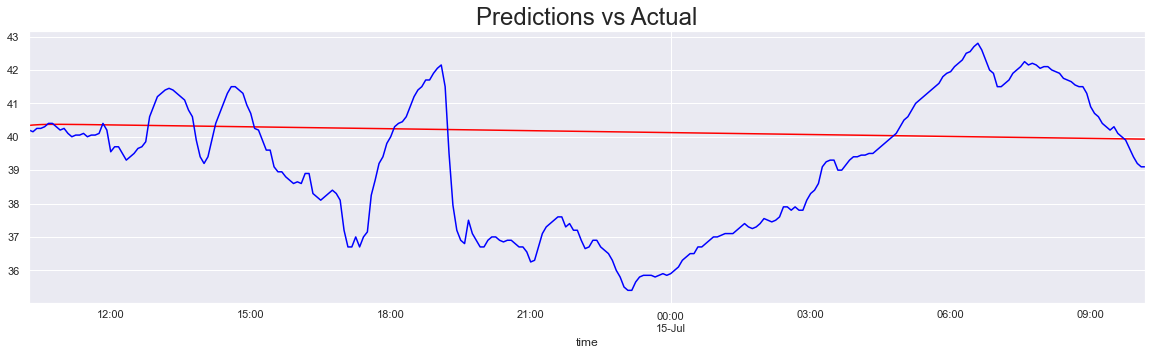

ABSOLUTE ERROR 1.8222755875403844
MSE 4.936915533576223


In [77]:
start_date = df_test.index[0]
end_date = df_test.index[len(df_test)-1]

df_pred = results_h_ar_1_i_2_ma_3.predict(start = start_date, end = end_date)

df_pred[start_date:end_date].plot(figsize = (20,5), color = "red")
df_test.humidity[start_date:end_date].plot(color = "blue")
plt.title("Predictions vs Actual", size = 24)
plt.show()                          

print("ABSOLUTE ERROR "+str(mean_absolute_error(df_test.humidity[start_date:end_date], df_pred[start_date:end_date])))
print("MSE "+str(mean_squared_error(df_test.humidity[start_date:end_date], df_pred[start_date:end_date])))

In [ ]:
print("\nARIMA(1,2,3)") 
results_h_ar_1_i_2_ma_3 = SARIMAX(df_train.humidity, order=(1,2,3), seasonal_order = (0,1,0,points_per_day)).fit()
print(results_h_ar_1_i_2_ma_3.summary())
#ARIMA(1,2,3):  	 LL =  579.1807345954734 	 AIC =  -1148.3614691909468


ARIMA(1,2,3)


## Pressure

### AR

In [45]:
model_p_ar_1 = ARIMA(df.pressure, order=(1,0,0))
results_p_ar_1 = model_p_ar_1.fit()
print(results_p_ar_1.summary())
model_p_ar_2 = ARIMA(df.pressure, order=(2,0,0))
results_p_ar_2 = model_p_ar_2.fit()
print(results_p_ar_2.summary())
model_p_ar_3 = ARIMA(df.pressure, order=(3,0,0))
results_p_ar_3 = model_p_ar_2.fit()
print(results_p_ar_3.summary())

                              ARMA Model Results                              
Dep. Variable:               pressure   No. Observations:                 3168
Model:                     ARMA(1, 0)   Log Likelihood                1411.340
Method:                       css-mle   S.D. of innovations              0.155
Date:                Sat, 18 Jul 2020   AIC                          -2816.680
Time:                        15:58:10   BIC                          -2798.497
Sample:                    07-07-2020   HQIC                         -2810.157
                         - 07-18-2020                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const           1019.0477      1.246    817.557      0.000    1016.605    1021.491
ar.L1.pressure     0.9981      0.001   1043.809      0.000       0.996       1.000
                                    

In [46]:
print("\nLLR test AR(1)-AR(2) = " + str(LLR_test(results_h_ar_1, results_h_ar_2)))
print("\nLLR test AR(1)-AR(3) = " + str(LLR_test(results_h_ar_1, results_h_ar_3, DF = 2)))
print("\nLLR test AR(2)-AR(3) = " + str(LLR_test(results_h_ar_2, results_h_ar_3)))


LLR test AR(1)-AR(2) = 1.0

LLR test AR(1)-AR(3) = 0.0

LLR test AR(2)-AR(3) = 0.0


In [48]:
df_pred = results_p_ar_1.predict(start = start_date, end = end_date)
print("MSE AR(1)"+str(mean_squared_error(df_test.pression[start_date:end_date], df_pred[start_date:end_date])))

df_pred = results_p_ar_2.predict(start = start_date, end = end_date)
print("MSE AR(2)"+str(mean_squared_error(df_test.pression[start_date:end_date], df_pred[start_date:end_date])))

df_pred = results_p_ar_3.predict(start = start_date, end = end_date)
print("MSE AR(3)"+str(mean_squared_error(df_test.pression[start_date:end_date], df_pred[start_date:end_date])))

AttributeError: 'DataFrame' object has no attribute 'pression'

### MA

In [ ]:
print("MA(1)")
model_p_ma_1 = ARMA(df.pressure, order=(0,1))
results_p_ma_1 = model_p_ma_1.fit()
print(results_p_ma_1.summary())

print("\nMA(2)")
model_p_ma_2 = ARMA(df.pressure, order=(0,2))
results_p_ma_2 = model_p_ma_2.fit()
print(results_p_ma_2.summary())

In [ ]:
print("\nLLR test MA(1)-MA(2) = " + str(LLR_test(results_p_ma_1, results_p_ma_2)))

In [ ]:
df_pred = results_p_ma_1.predict(start = start_date, end = end_date)
print("MSE MA(1)"+str(mean_squared_error(df_test.pression[start_date:end_date], df_pred[start_date:end_date])))

df_pred = results_p_ma_2.predict(start = start_date, end = end_date)
print("MSE MA(2)"+str(mean_squared_error(df_test.pression[start_date:end_date], df_pred[start_date:end_date])))

### ARMA

In [ ]:
print("\nARMA(1,1)")
reults_p_ar_1_ma_1 = SARIMAX(df_train.humidity, order=(1,1)).fit()
print(reults_p_ar_1_ma_1.summary())

print("\nARMA(2,1)") #NON SIGNIFICATIVO
reults_p_ar_2_ma_1 = SARIMAX(df_train.humidity, order=(2,1)).fit()
print(reults_p_ar_2_ma_1.summary())

print("\nARMA(1,2)")
reults_p_ar_1_ma_2 = SARIMAX(df_train.humidity, order=(1,2)).fit()
print(reults_p_ar_1_ma_2.summary())

print("\nARMA(2,2)") 
reults_p_ar_2_ma_2 = SARIMAX(df_train.humidity, order=(2,2)).fit()
print(reults_p_ar_2_ma_2.summary())

print("\nARMA(3,1)") 
reults_p_ar_3_ma_1 = SARIMAX(df_train.humidity, order=(3,1)).fit()
print(reults_p_ar_3_ma_1.summary())

print("\nARMA(1,3)")
reults_p_ar_1_ma_3 = SARIMAX(df_train.humidity, order=(1,3)).fit()
print(reults_p_ar_1_ma_3.summary())

print("\nARMA(3,2)") #NON SIGNIFICATIVO
reults_p_ar_3_ma_2 = SARIMAX(df_train.humidity, order=(3,2)).fit()
print(reults_p_ar_3_ma_2.summary())

print("\nARMA(2,3)") #NON SIGNIFICATIVO
reults_p_ar_2_ma_3 = SARIMAX(df_train.humidity, order=(2,3)).fit()
print(reults_p_ar_2_ma_3.summary())

print("\nARMA(3,3)") #NON SIGNIFICATIVO
reults_p_ar_3_ma_3 = SARIMAX(df_train.humidity, order=(3,3)).fit()
print(reults_p_ar_3_ma_3.summary())

In [ ]:
#print("ARMA(1,1):  \t LL = ", reults_h_ar_1_ma_1.llf, "\t AIC = ", reults_h_ar_1_ma_1.aic)
#print("ARMA(2,1):  \t LL = ", reults_h_ar_2_ma_1.llf, "\t AIC = ", reults_h_ar_2_ma_1.aic)
#print("ARMA(1,2):  \t LL = ", reults_h_ar_1_ma_2.llf, "\t AIC = ", reults_h_ar_1_ma_2.aic)
#print("ARMA(2,2):  \t LL = ", reults_h_ar_2_ma_2.llf, "\t AIC = ", reults_h_ar_2_ma_2.aic)

#print("\nAR(2) vs ARMA(1,1) ",LLR_test(results_h_ar_2, reults_h_ar_1_ma_1))
#print("\nAR(2) vs ARMA(2,1) ",LLR_test(results_h_ar_2, reults_h_ar_2_ma_1))
#print("\nAR(2) vs ARMA(1,2) ",LLR_test(results_h_ar_2, reults_h_ar_1_ma_2))
#print("\nAR(2) vs ARMA(2,2) ",LLR_test(results_h_ar_2, reults_h_ar_2_ma_2))

### ARIMA

In [ ]:
print("\nARIMA(1,1,1)") 
results_p_ar_1_i_1_ma_1 = SARIMAX(df.pressure, order=(1,1,1)).fit()
print(results_p_ar_1_i_1_ma_1.summary())

print("\nARIMA(2,1,1)") #NON STAZIONARIO
results_p_ar_2_i_1_ma_1 = SARIMAX(df.pressure, order=(2,1,1)).fit()
print(results_p_ar_2_i_1_ma_1.summary())

print("\nARIMA(1,1,2)") #NON STAZIONARIO
results_p_ar_1_i_1_ma_2 = SARIMAX(df.pressure, order=(1,1,2)).fit()
print(results_p_ar_1_i_1_ma_2.summary())

print("\nARIMA(2,1,2)") #NON STAZIONARIO
results_p_ar_2_i_1_ma_2 = SARIMAX(df.pressure, order=(2,1,2)).fit()
print(results_p_ar_2_i_1_ma_2.summary())

############################

print("\nARIMA(1,2,1)")
results_p_ar_1_i_2_ma_1 = SARIMAX(df.pressure, order=(1,2,1)).fit()
print(results_p_ar_1_i_2_ma_1.summary())

print("\nARIMA(2,2,1)") #NON SIGNIFICATIVO
results_p_ar_2_i_2_ma_1 = SARIMAX(df.pressure, order=(2,2,1)).fit()
print(results_p_ar_2_i_2_ma_1.summary())

print("\nARIMA(1,2,2)") #NON SIGNIFICATIVO
results_p_ar_1_i_2_ma_2 = SARIMAX(df.pressure, order=(1,2,2)).fit()
print(results_p_ar_1_i_2_ma_2.summary())

print("\nARIMA(2,2,2)") #NON SIGNIFICATIVO
results_p_ar_2_i_2_ma_2 = SARIMAX(df.pressure, order=(2,2,2)).fit()
print(results_p_ar_2_i_2_ma_2.summary())

In [ ]:
print("ARMA(1,1,1):  \t LL = ", results_p_ar_1_i_1_ma_1.llf, "\t AIC = ", results_p_ar_1_i_1_ma_1.aic)
#print("ARMA(2,1,1):  \t LL = ", results_p_ar_2_i_1_ma_1.llf, "\t AIC = ", results_p_ar_2_i_1_ma_1.aic)
#print("ARMA(1,1,2):  \t LL = ", results_p_ar_1_i_1_ma_2.llf, "\t AIC = ", results_p_ar_1_i_1_ma_2.aic)
#print("ARMA(2,1,2):  \t LL = ", results_p_ar_2_i_1_ma_2.llf, "\t AIC = ", results_p_ar_2_i_1_ma_2.aic)

print("ARMA(1,2,1):  \t LL = ", results_p_ar_1_i_2_ma_1.llf, "\t AIC = ", results_p_ar_1_i_2_ma_1.aic)
#print("ARMA(2,2,1):  \t LL = ", results_p_ar_2_i_2_ma_1.llf, "\t AIC = ", results_p_ar_2_i_2_ma_1.aic)
#print("ARMA(1,2,2):  \t LL = ", results_p_ar_1_i_2_ma_2.llf, "\t AIC = ", results_p_ar_1_i_2_ma_2.aic)
#print("ARMA(2,2,2):  \t LL = ", results_p_ar_2_i_2_ma_2.llf, "\t AIC = ", results_p_ar_2_i_2_ma_2.aic)

#Ha vinto (1,1,1) e secondo LLR non vale la pena di utilizzarlo
print("\nAR(1) vs ARIMA(1,1,1) ",LLR_test(results_p_ar_1, results_p_ar_1_i_1_ma_1))
print("\nMA(1) vs ARIMA(1,1,1) ",LLR_test(results_p_ma_2, results_p_ar_1_i_1_ma_1))

## Auto ARIMA

In [ ]:
from pmdarima.arima import auto_arima
model_t_auto = auto_arima(df.temperature[1:], exogenous = df[['humidity', 'pressure']][1:], 
                         m=145, max_order = None, max_p = 7, max_q = 7, max_d = 2, max_P = 4, 
                         max_Q = 4, max_D = 2, maxiter = 50, alpha = 0.05, n_jobs = -1, trend = 'ct')
model_t_auto.summary()

In [ ]:
from  pmdarima.arima import auto_arima
mode_auto = auto_arima(df_train.temperature)

In [ ]:
mode_auto.summary()

In [ ]:
auto = SARIMAX(df_train.temperature, order=(2,1,2)).fit()
auto.summary()
df_pred = auto.predict(start = start_date, end = end_date)
print("MSE "+str(mean_squared_error(df_test.humidity[start_date:end_date], df_pred[start_date:end_date])))